In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imread
import scipy
from skimage.transform import resize
from PIL import Image
from scipy import ndimage
from dnn_app_utils import *
from sklearn.model_selection import train_test_split
import math

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2


In [2]:
x, y = load_data()

In [3]:
train_x, test_x, train_y, test_y =  train_test_split(x, y, test_size=0.33, random_state=84)

In [4]:
tr = np.array(train_y)
ts = np.array(test_y)

print("Number of PIZZAS in training: {}".format(len(np.where(tr == 1)[0])))
print("Number of NON-PIZZAS in training: {}".format(len(np.where(tr == 0)[0])))

print("Number of PIZZAS in test: {}".format(len(np.where(ts == 1)[0])))
print("Number of NON-PIZZAS in test: {}".format(len(np.where(ts == 0)[0])))

Number of PIZZAS in training: 660
Number of NON-PIZZAS in training: 343
Number of PIZZAS in test: 313
Number of NON-PIZZAS in test: 182


In [5]:
train_x_orig = np.array(train_x)
test_x_orig = np.array(test_x)
train_y = np.array([train_y])
test_y = np.array([test_y])

In [6]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

In [7]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

train_x = train_x_flatten
test_x = test_x_flatten

In [8]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:,k * mini_batch_size:(k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:,k * mini_batch_size:(k + 1) * mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        final_batch_size = m-mini_batch_size*(m/mini_batch_size)
        mini_batch_X = shuffled_X[:,num_complete_minibatches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[:,num_complete_minibatches * mini_batch_size:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [9]:
def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros_like(parameters["W" + str(l+1)])
        v["db" + str(l+1)] = np.zeros_like(parameters["b" + str(l+1)])
        s["dW" + str(l+1)] = np.zeros_like(parameters["W" + str(l+1)])
        s["db" + str(l+1)] = np.zeros_like(parameters["b" + str(l+1)])
    
    return v, s

In [10]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01, beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    Update parameters using Adam
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        v["dW" + str(l + 1)] = beta1 * v["dW" + str(l + 1)] + (1 - beta1) * grads['dW' + str(l + 1)]
        v["db" + str(l + 1)] = beta1 * v["db" + str(l + 1)] + (1 - beta1) * grads['db' + str(l + 1)]

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        v_corrected["dW" + str(l+1)] = (v['dW' + str(l+1)])/(1-(beta1**t))
        v_corrected["db" + str(l+1)] = (v['db' + str(l+1)])/(1-(beta1**t))

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        s["dW" + str(l+1)] = beta2*(s['dW' + str(l+1)]) + (1-beta2)*((grads["dW" + str(l+1)])**2)
        s["db" + str(l+1)] = beta2*(s['db' + str(l+1)]) + (1-beta2)*((grads["db" + str(l+1)])**2)

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        s_corrected["dW" + str(l+1)] = (s['dW' + str(l+1)])/(1-(beta2**t))
        s_corrected["db" + str(l+1)] = (s['db' + str(l+1)])/(1-(beta2**t))

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*v_corrected['dW' +str(l+1)]/(s_corrected['dW' + str(l+1)]+epsilon)**(1/2)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*v_corrected['db' +str(l+1)]/(s_corrected['db' + str(l+1)]+epsilon)**(1/2)

    return parameters, v, s

In [19]:
def L_layer_model(X, Y, layers_dims, test_x, test_y, lambd=0, learning_rate = 0.0007, mini_batch_size = 32, beta = 0.9,
                beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8, num_epochs = 200, print_cost=True):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    
    L = len(layers_dims)
    costs = [] # keep track of cost
    prediction_test = [] #keep track of prediction accuracy (test_data)
    prediction_train = [] # keep track of prediciton accuracy (train_data)
        
    t = 0 #Initialize the counter required for Adam update
    seed = 10 
    m = X.shape[1] #number of training examples
    
    # Parameters initialization.
    parameters = initialize_parameters_he(layers_dims)
    
    # Initialize the otimizer Adam
    v, s = initialize_adam(parameters)
    
    # Initial predict to track accuracy
    p, accuracy = predict(test_x, test_y, parameters) 
    prediction_test.append(float(accuracy))
    
    p, accuracy = predict(X, Y, parameters) 
    prediction_train.append(float(accuracy))
    
    # Loop (gradient descent)
    for i in range(num_epochs):
        
        #Define the random minibatches. We increment the seed to reshuffle differently the datset after each epoch
        seed += 1
        
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:
            
            #Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch
            
            # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
            AL, caches = L_model_forward(minibatch_X, parameters)
        
            # Compute cost.
            if lambd == 0:
                cost_total += compute_cost(AL, minibatch_Y)
            else:
                cost_total += compute_cost_with_regularization(AL, minibatch_Y, parameters, lambd)
            
            # Backward propagation.
            if lambd == 0:
                grads = back_propagation(AL, minibatch_Y, caches)
            else:
                grads = backward_with_regularization(AL, minibatch_Y, caches, lambd)

            # Update parameters.
            t = t + 1 # Adam counter
            parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2, epsilon)
            
        #Compute the avarege cost for the actual minibacth
        cost_avg = cost_total/m
        costs.append(cost_avg)

        # Print the cost every 100 training example
        if print_cost and i % 5 == 0 and i != 0:
            
            p, accuracy_test = predict(test_x, test_y, parameters) #predict the test_data
            p, accuracy_train = predict(X, Y, parameters) #predict the train_data
            print("Accuracy (train): {0}".format(accuracy_train))
            print("Accuracy (test): {0}".format(accuracy_test))
            
            print ("Cost after epoch %i: %f" %(i, cost_avg))            
            print("---------------------------------------")
            
            prediction_test.append(float(accuracy_test))
            prediction_train.append(float(accuracy_train))
            
            if float(accuracy_test) > 0.785:
                break
                break
        

    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per five)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.grid(True)
    plt.show()
    
    plt.plot(np.squeeze(prediction_test), label='test')
    plt.plot(np.squeeze(prediction_train), label="train")
    plt.xlabel("iterations (per five)")
    plt.ylabel("accuracy")
    plt.grid(True)
    plt.show()
    return parameters

In [20]:
layers_dims = [12288, 20, 20, 20, 15, 10, 7, 5, 1] #  8-layer model

Accuracy (train): 0.7507477567298104
Accuracy (test): 0.7818181818181816
Cost after epoch 5: 0.073976
---------------------------------------
Accuracy (train): 0.7387836490528412
Accuracy (test): 0.713131313131313
Cost after epoch 10: 0.056483
---------------------------------------
Accuracy (train): 0.8105682951146558
Accuracy (test): 0.7393939393939393
Cost after epoch 15: 0.047686
---------------------------------------
Accuracy (train): 0.8584247258225322
Accuracy (test): 0.7454545454545453
Cost after epoch 20: 0.039758
---------------------------------------
Accuracy (train): 0.867397806580259
Accuracy (test): 0.7474747474747473
Cost after epoch 25: 0.034944
---------------------------------------
Accuracy (train): 0.84247258225324
Accuracy (test): 0.7434343434343432
Cost after epoch 30: 0.031166
---------------------------------------
Accuracy (train): 0.8973080757726816
Accuracy (test): 0.7494949494949493
Cost after epoch 35: 0.028864
---------------------------------------
Accu

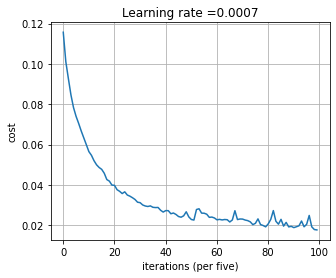

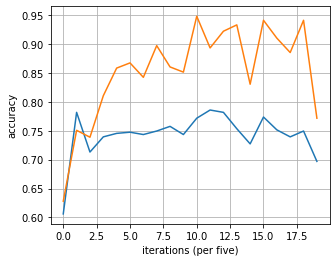

In [21]:
parameters = L_layer_model(train_x, train_y, layers_dims, test_x, test_y, lambd = 1, num_epochs=100, print_cost = True)

In [22]:
pred_train, acc = predict(train_x, train_y, parameters)
print("Acc: ", acc)

Acc:  0.9451645064805579


In [23]:
pred_test, acc = predict(test_x, test_y, parameters)
print("Acc: ", acc)

Acc:  0.7535353535353534


In [ ]:
analysis = false_and_positives_analysis(pred_test, test_y)